In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('/home/jupyter-india/data-for-eqs-gb-norm-of-b/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('/home/jupyter-india/data-for-eqs-gb-norm-of-b/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('/home/jupyter-india/data-for-eqs-gb-norm-of-b/icegrav_synthetic_sources.csv', header=0)

coordinates = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 25)]).T

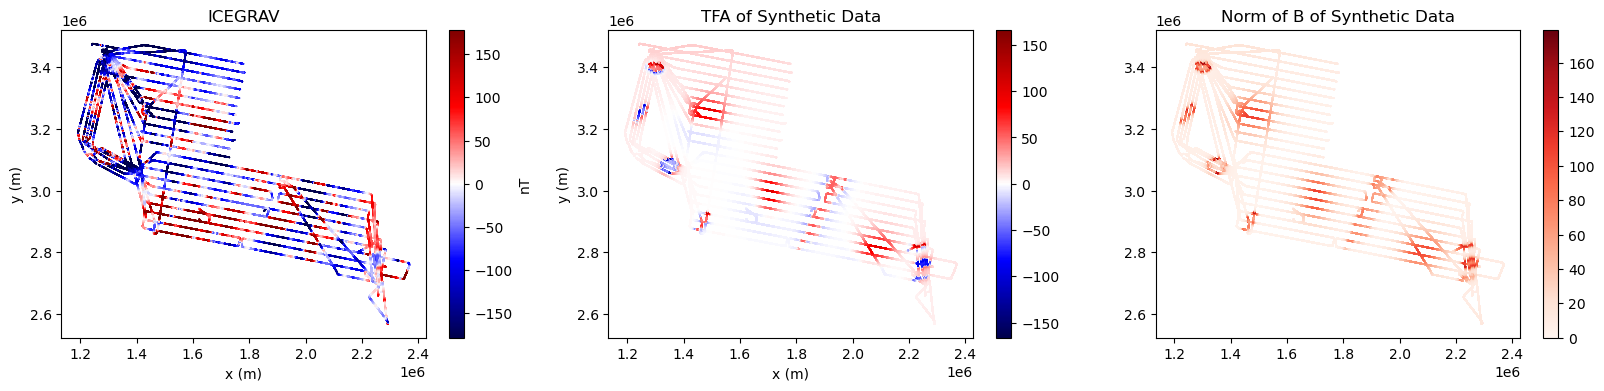

In [4]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*coordinates[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("ICEGRAV")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale = vd.maxabs(icegrav_synthetic.tfa)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()
plt.subplot(1,3,3)
scale = vd.maxabs(icegrav_synthetic.bnorm)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.bnorm, cmap="Reds",s=0.01, vmin=0, vmax=scale)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

In [5]:
grid_spacing = 1e3
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=4.5e4, coordinates=grid_coordinates)
# mask = vd.convexhull_mask(coordinates, grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = np.sqrt(sum(c**2 for c in true_b))

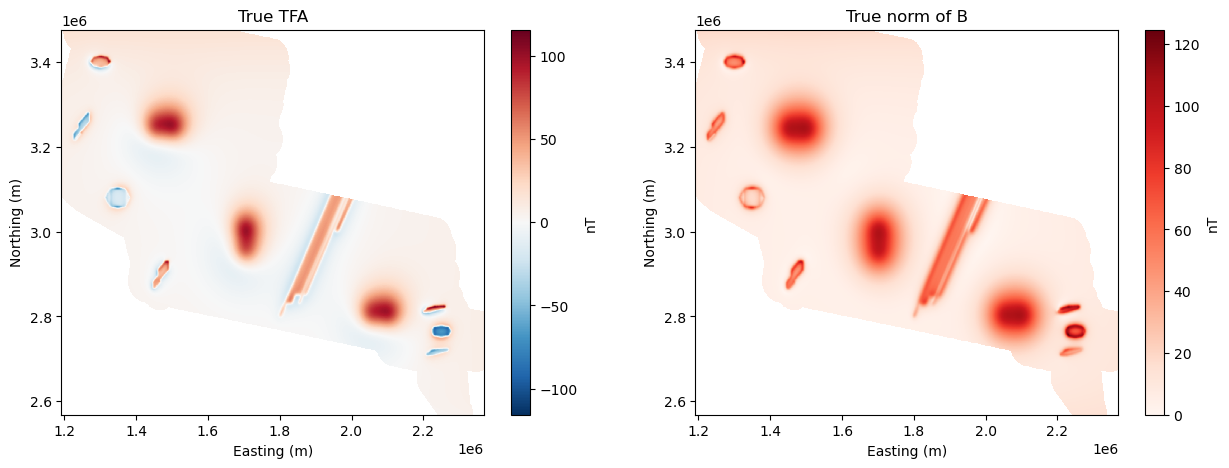

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,2,2)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

### Block average

In [7]:
region = vd.get_region(coordinates)
block_spacing = 2e4
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.5)),
    drop_coords=False
)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

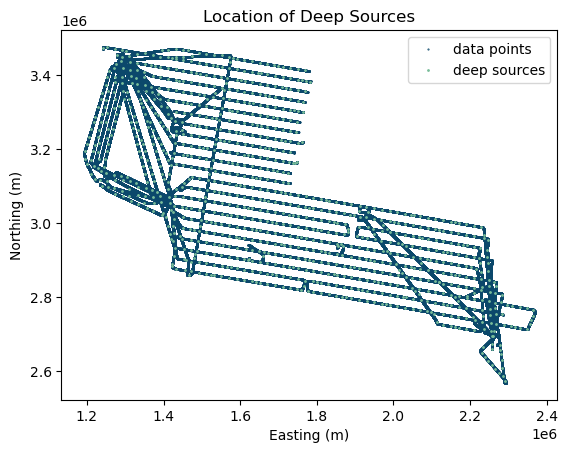

In [8]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#79BD9A", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

### Find optimal damping and depth

In [9]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep_eqs = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.25, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
dampings_deep_eqs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
# depths_deep_eqs = [spacing*3, spacing*3.5, spacing*4]
# dampings_deep_eqs = [1e1, 1e2, 1e3]

In [11]:
parameter_sets_deep_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets_deep_eqs))

Number of combinations: 99


In [12]:
%%time
kfold = vd.BlockKFold(
    spacing=3.5e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_deep_eqs:    
    # print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

best_deep = np.argmin(scores)
parameter_sets_deep_eqs[best_deep]

CPU times: user 22min 51s, sys: 10min, total: 32min 52s
Wall time: 57.1 s


{'damping': 100000.0, 'depth': 37281.09268971386}

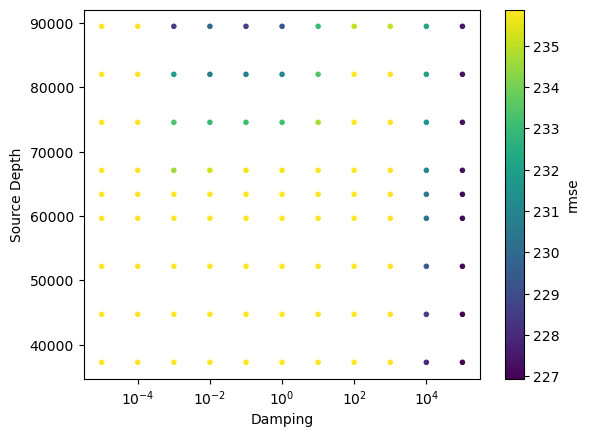

In [13]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

###  Deep prediction

In [13]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep_eqs[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -34393.892689713866
CPU times: user 1.19 s, sys: 328 ms, total: 1.51 s
Wall time: 45.7 ms


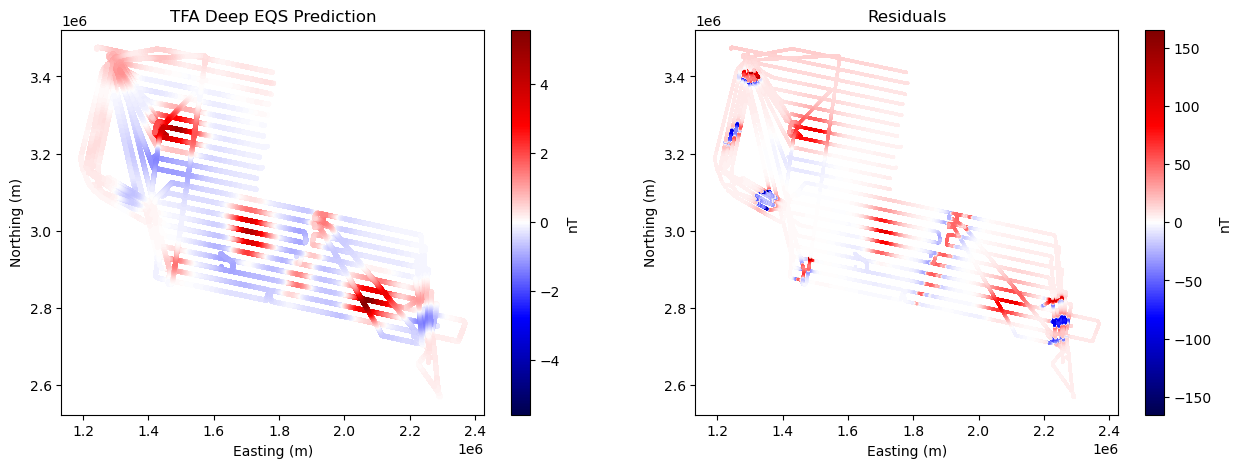

In [14]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

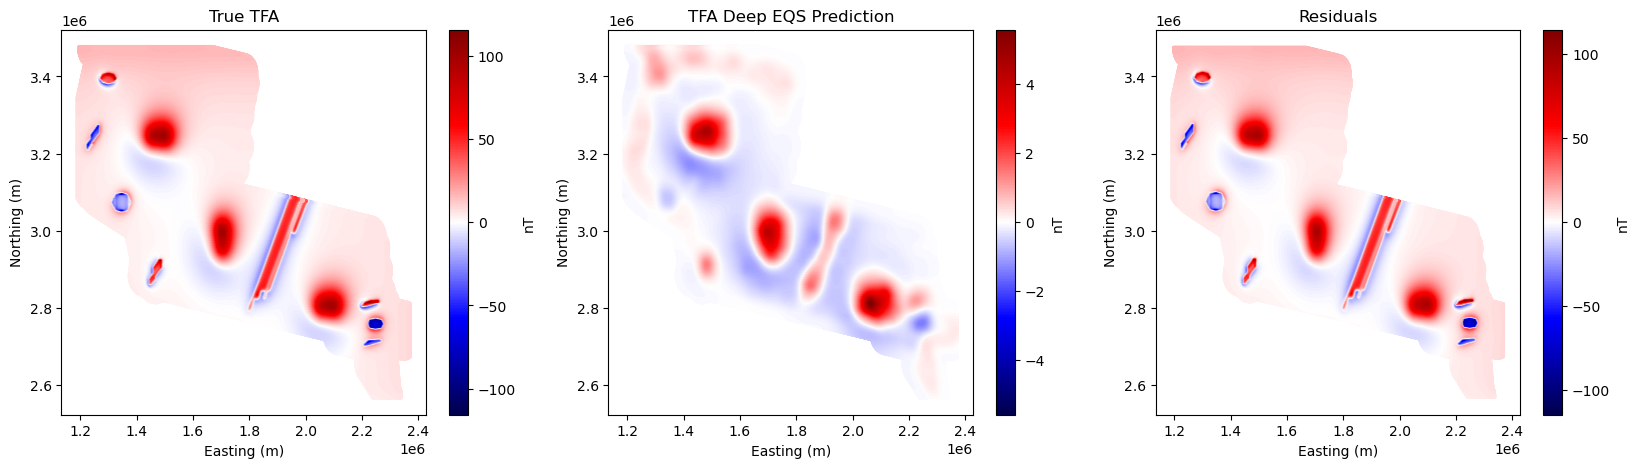

In [15]:
tfa_deep_grid = eqs.total_field_anomaly(eqs_deep.predict(grid_coords_masked), field_direction)
tfa_residuals_grid = true_tfa- tfa_deep_grid
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.scatter(*grid_coords_masked[:2], c=true_tfa, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale = vd.maxabs(tfa_deep_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_deep_grid, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,3)
scale = vd.maxabs(tfa_residuals_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_residuals_grid, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

### Find optimal damping and depth

In [16]:
dampings_shallow_eqs = [1e5, 1e6, 1e7]
depths_shallow_eqs = [29e3, 30e3, 31e3]

# dampings_shallow_eqs = [1e6]
# depths_shallow_eqs = [31e3]

parameter_sets_shallow_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow_eqs, depths_shallow_eqs)
]
print("Number of combinations:", len(parameter_sets_shallow_eqs))

Number of combinations: 9


In [17]:
%%time
kfold = vd.BlockKFold(
    spacing=3e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_shallow_eqs:    
    print(parameters)
    tmp = []
    for train, test in kfold.split(features):
        df = pd.DataFrame(np.transpose([c[train] for c in coordinates]), columns=['x', 'y', 'z'])
        shallow_block_coords, labels = vd.block_split([c[train] for c in coordinates], shape=(6,6))
        block_point_size = df['x'].groupby(by=labels).count()
        eqs_depth = []
        constant = 2e8
        for i in labels:
            eqs_depth.append(parameters['depth'] + (constant * 1/block_point_size[i]))
        eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=5e4,
            damping=parameters['damping'],
            depth=eqs_depth
        )
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])
best_shallow = np.argmin(scores)
parameter_sets_shallow_eqs[best_shallow]

{'damping': 100000.0, 'depth': 29000.0}
{'damping': 100000.0, 'depth': 30000.0}
{'damping': 100000.0, 'depth': 31000.0}
{'damping': 1000000.0, 'depth': 29000.0}
{'damping': 1000000.0, 'depth': 30000.0}
{'damping': 1000000.0, 'depth': 31000.0}
{'damping': 10000000.0, 'depth': 29000.0}
{'damping': 10000000.0, 'depth': 30000.0}
{'damping': 10000000.0, 'depth': 31000.0}
CPU times: user 1d 2h 2min 51s, sys: 7h 32min 16s, total: 1d 9h 35min 8s
Wall time: 59min 57s


{'damping': 1000000.0, 'depth': 31000.0}

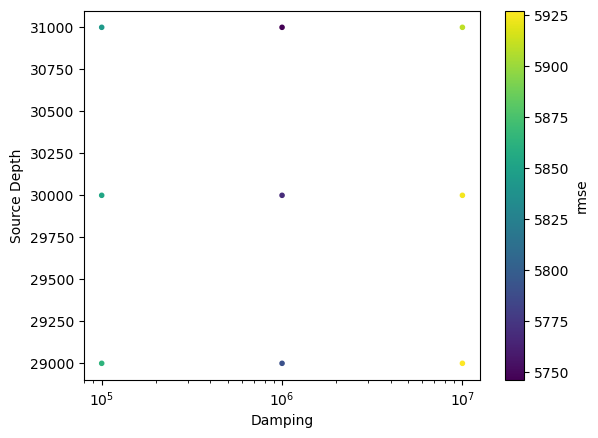

In [18]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,90),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

### Find optimal window size

In [19]:
window_sizes = [1e4, 2e4, 3e4, 4e4, 5e4]

In [20]:
%%time
kfold = vd.BlockKFold(
    spacing=3e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
window = []
for i in window_sizes:    
    print(i)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
        random_state=0,
        block_size=grid_spacing,
        window_size=i,
        **parameter_sets_shallow_eqs[best_shallow]
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    #print(tmp)
    scores.append(np.mean(tmp))
    window.append(i)

best_window_size = np.argmin(scores)
print('optimal window size =', window_sizes[best_window_size])

10000.0
20000.0
30000.0
40000.0
50000.0
optimal window size = 30000.0
CPU times: user 19h 13min 35s, sys: 3h 47min 26s, total: 23h 1min 1s
Wall time: 39min 45s


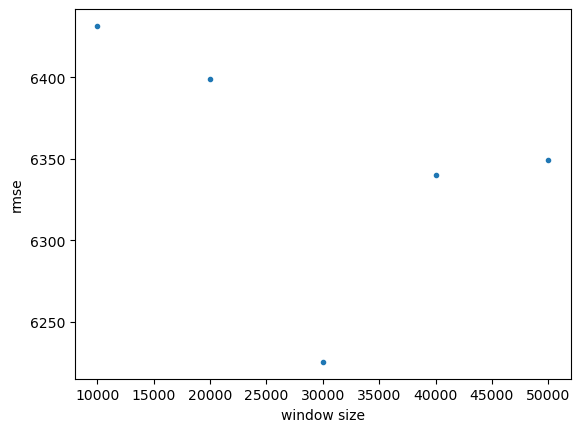

In [21]:
plt.figure()
plt.plot(window, scores, '.')
plt.xlabel('window size')
plt.ylabel('rmse')
plt.show()

### Shallow Prediction

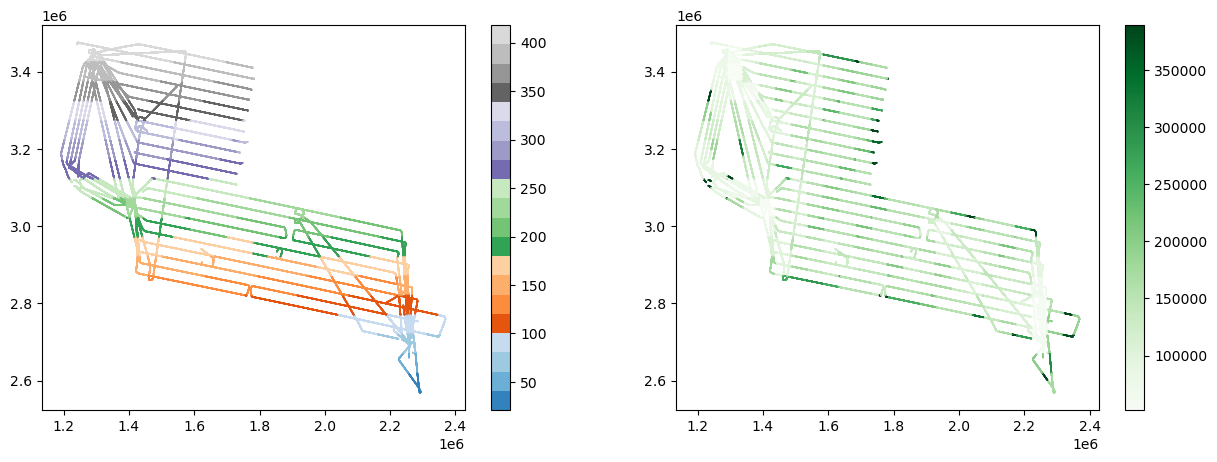

In [29]:
df = pd.DataFrame(np.transpose(coordinates[:2]), columns=['x', 'y'])
shallow_block_coords, labels = vd.block_split(coordinates, spacing=5e4)
block_point_size = df['x'].groupby(by=labels).count()
eqs_depth = []
constant = 2e8
for i in labels:
    eqs_depth.append(parameter_sets_shallow_eqs[best_shallow]['depth'] + (constant * 1/block_point_size[i]))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=labels, cmap='tab20c', s=0.001,)# vmin=np.min(eqs_depth), vmax=np.max(eqs_depth))
plt.colorbar()
plt.subplot(1,2,2)
scale = np.percentile(eqs_depth, 99)
plt.scatter(*coordinates[:2], c=eqs_depth, cmap='Greens', s=0.001, vmin=np.min(eqs_depth), vmax=scale)
plt.colorbar()
plt.show()

In [23]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_sizes[best_window_size],
    damping=parameter_sets_shallow_eqs[best_shallow]['damping'],
    depth= eqs_depth,
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 2h 31min 58s, sys: 32min 32s, total: 3h 4min 31s
Wall time: 5min 17s


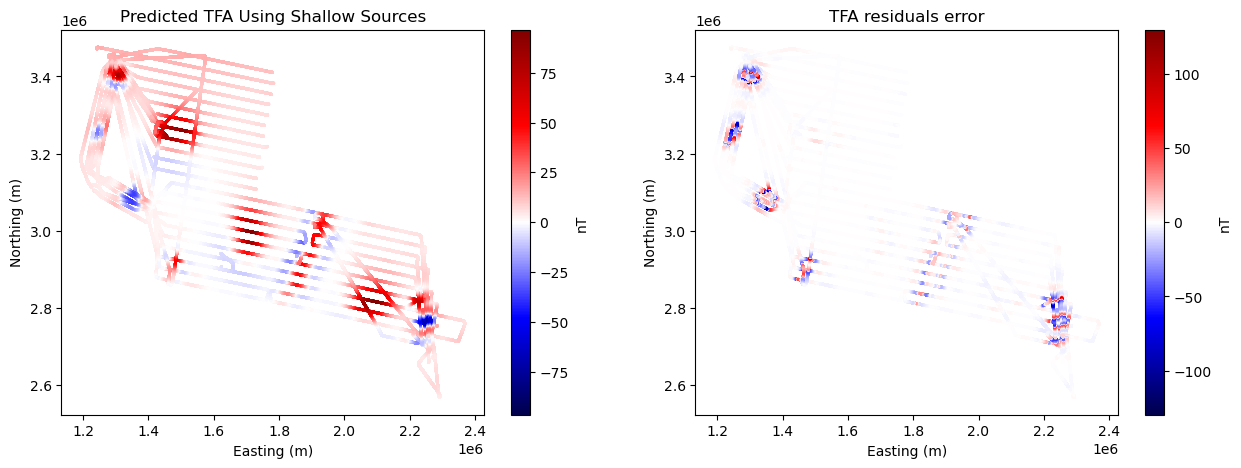

In [24]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa_residuals_prediction)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel( "Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [25]:
predicted_b = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa
rmse_tfa = np.sqrt(np.square(~np.isnan(error_tfa)).mean())

predicted_bnorm = np.sqrt(sum(c**2 for c in predicted_b))
error_bnorm = true_bnorm - predicted_bnorm
rmse_bnorm = np.sqrt(np.square(~np.isnan(error_bnorm)).mean())

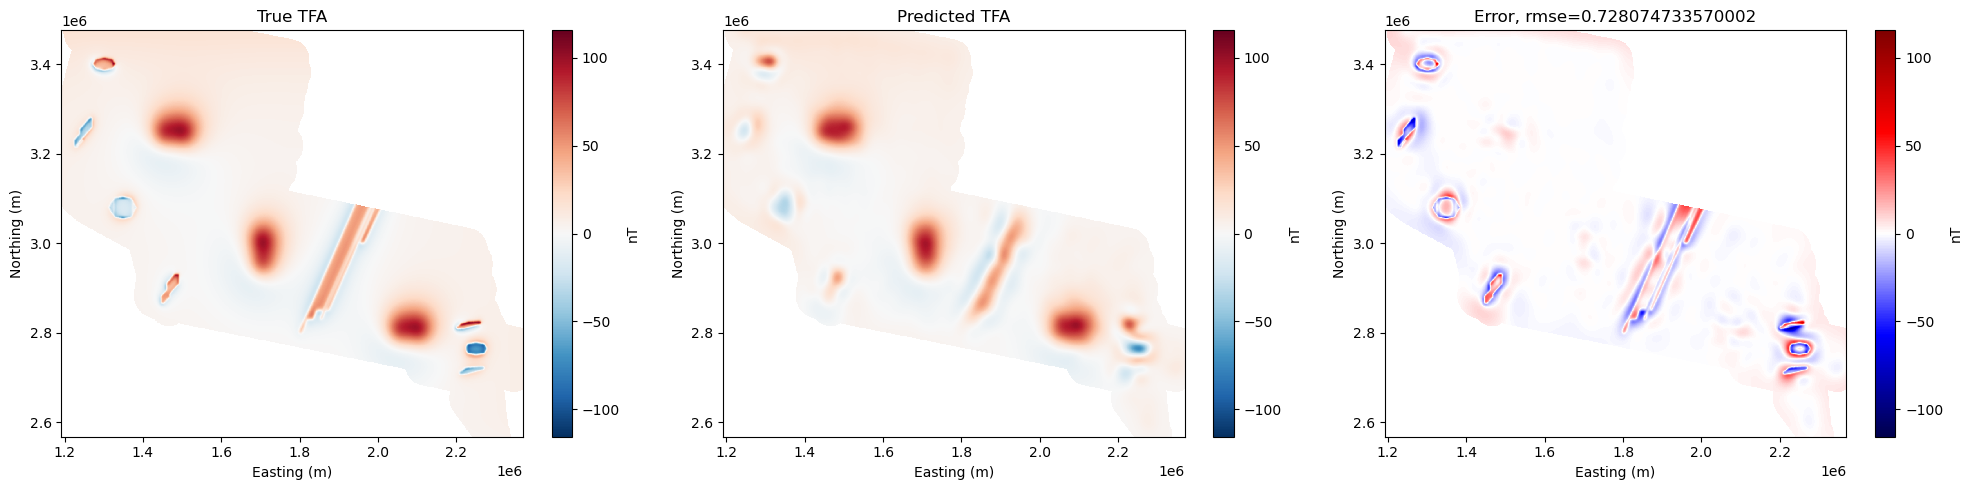

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
#scale = np.nanpercentile(predicted_tfa, 99)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
#scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-scale, vmax=scale)
# plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_tfa))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

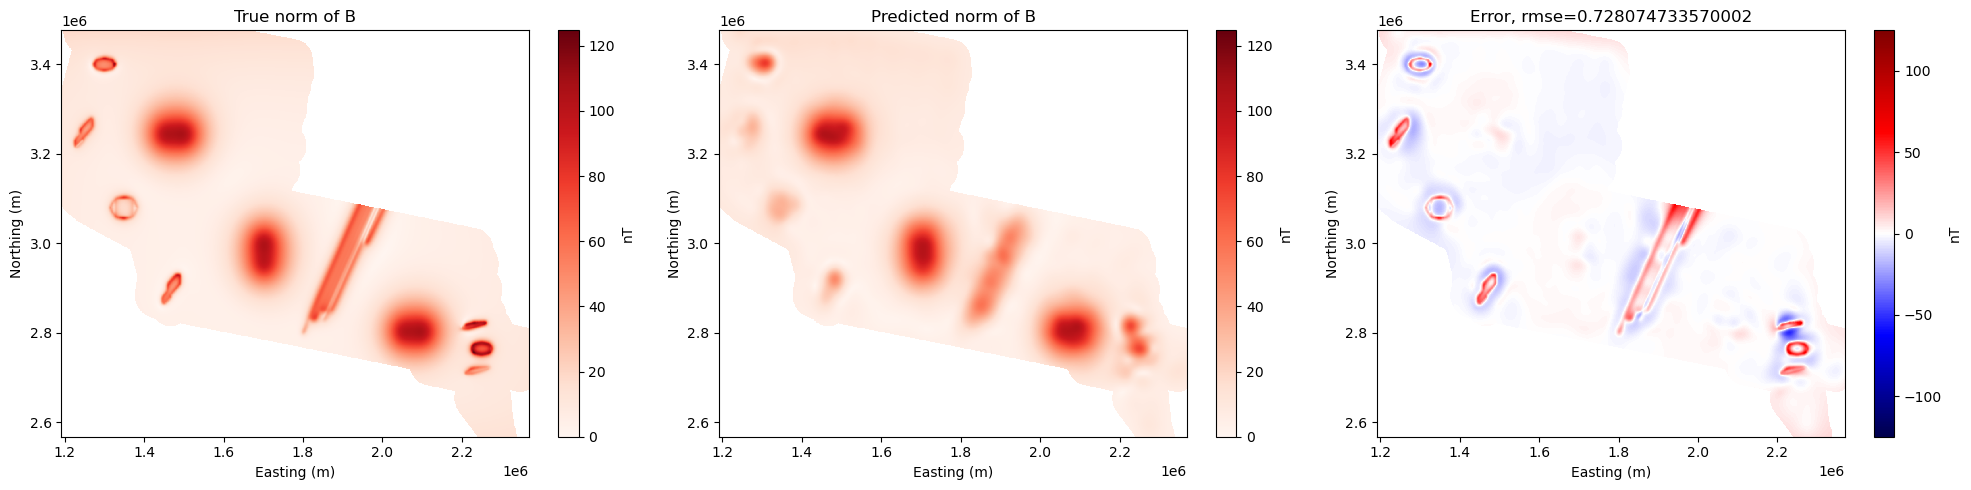

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
#scale = vd.maxabs(predicted_bnorm)
plt.pcolormesh(*grid_coordinates[:2], predicted_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
#scale = vd.maxabs(error_bnorm)
plt.pcolormesh(*grid_coordinates[:2], error_bnorm, cmap="seismic", vmin=-scale, vmax=scale)
#plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_bnorm))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()